In [1]:
from imports.ExtractContactCases import ExtractContactCases

ex = ExtractContactCases(
    '../data/bags/data2/',
    '../data/extractions/contact_extraction5/',
    n_init_events = 7500
)

#ex.extract()

In [45]:
from imports.TactileBag import TactileBag

In [46]:
tbag = TactileBag('../data/bags/data2/')
df = tbag.parsed_bag
df

,ts,contact_status,contact_case,contact_angle_x,contact_angle_y,contact_angle_z
0,1672235485049392995,False,0.0,0.001636,0.000830,0.002355
1,1672235485086052833,False,0.0,0.001678,0.000865,0.002270
2,1672235485103664372,False,0.0,0.001699,0.000899,0.002283
3,1672235485131136692,False,0.0,0.001646,0.000848,0.002319
4,1672235485148841329,False,0.0,0.001657,0.000877,0.002295
...,...,...,...,...,...,...
508727,1672246958274827871,False,0.0,0.176380,0.000774,0.002480
508728,1672246958290677711,False,0.0,0.176479,0.000865,0.002503
508729,1672246958303181902,False,0.0,0.176448,0.000805,0.002490
508730,1672246958333194754,False,0.0,0.176357,0.000800,0.002475


In [49]:
tbag.events[:1000].compute()

array([[                323,                 197, 1672235485038805634,
                          0],
       [                 66,                 257, 1672235485038822634,
                          0],
       [                239,                 101, 1672235485038894634,
                          1],
       ...,
       [                  5,                 113, 1672235485309432634,
                          0],
       [                187,                 113, 1672235485309679634,
                          0],
       [                 77,                 235, 1672235485309878634,
                          0]])

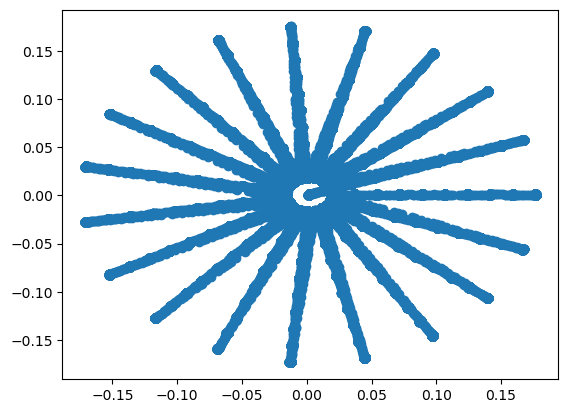

In [4]:
import matplotlib.pyplot as plt
plt.scatter(df['contact_angle_x'], df['contact_angle_y'])

In [5]:
import numpy as np

possible_angles = tbag.params['possible_angles']
N_examples = tbag.params['N_examples']
theta = tbag.params['theta']
list_of_rotations = [[0, 0, 0]]

sph = []

for i in range(1, N_examples):
    th = i * 2 * np.pi/(N_examples - 1) if theta=='full' else theta[i]#math.pi/2 #i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angles:
        sph.append([phi, th])
        rx = phi * np.cos(th)
        ry = phi * np.sin(th)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

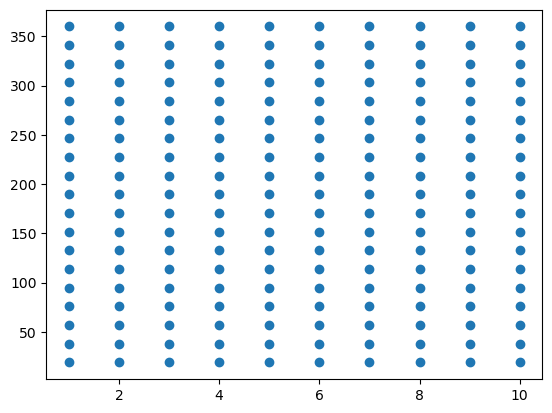

In [6]:
plt.scatter(*np.degrees(sph).T)

In [7]:
from imports.TactileDataset import TactileDataset
from imports.TrainModel import TrainModel
from models.modules import GraphRes


#from models.modules import GraphRes

#!rm -rf /content/drive/MyDrive/tactile/ex1/{test,train,val}/processed/*.pt
tm = TrainModel(
    '../data/extractions/contact_extraction5/', 
    GraphRes().cuda(), 
    lr=0.01, 
    features='pol', 
    batch=4, 
    n_epochs=300, 
    experiment_name='', 
    desc='aegnn model small on large data',
    merge_test_val=False
)

{'bag': '/home/hussain/me/projects/tactile/data/bags/data2', 'train_prop': 0.75, 'delta_t': 75000000.0, 'margin': -25000000.0, 'min_n_events': 750, 'n_init_events': 7500, 'center': [180, 117], 'circle_rad': 85, 'case_span': 2660000000.0, 'N_examples': 20, 'possible_angles': [0.017453292519943295, 0.03490658503988659, 0.05235987755982989, 0.06981317007977318, 0.08726646259971647, 0.10471975511965978, 0.12217304763960307, 0.13962634015954636, 0.15707963267948966, 0.17453292519943295], 'theta': 'full', 'augmentations': [], 'node_features': 'pol'}
{'bag': '/home/hussain/me/projects/tactile/data/bags/data2', 'train_prop': 0.75, 'delta_t': 75000000.0, 'margin': -25000000.0, 'min_n_events': 750, 'n_init_events': 7500, 'center': [180, 117], 'circle_rad': 85, 'case_span': 2660000000.0, 'N_examples': 20, 'possible_angles': [0.017453292519943295, 0.03490658503988659, 0.05235987755982989, 0.06981317007977318, 0.08726646259971647, 0.10471975511965978, 0.12217304763960307, 0.13962634015954636, 0.157

/home/hussain/me/projects/tactile/src/imports/TrainModel.py:39: UserWarning: experiment /home/hussain/me/projects/tactile/results already exists. Press enter to proceed overwriting.
  warnings.warn(f'experiment {str(path)} already exists. Press enter to proceed overwriting.')


In [8]:
import torch
tm.model.load_state_dict(torch.load('../results/msi/state_dict', map_location='cuda'))

<All keys matched successfully>

In [9]:
from torch_geometric.loader import DataLoader

vl = DataLoader(tm.val_data, batch_size=1)

In [10]:
tm.val_data[22]

Data(x=[7500, 1], edge_index=[2, 105788], y=[1, 2], pos=[7500, 3], edge_attr=[105788, 3])

In [11]:
for i in tm.val_loader:
    print(i)

DataBatch(x=[7500, 1], edge_index=[2, 102208], y=[1, 2], pos=[7500, 3], edge_attr=[102208, 3], batch=[7500], ptr=[2])
DataBatch(x=[3096, 1], edge_index=[2, 40578], y=[1, 2], pos=[3096, 3], edge_attr=[40578, 3], batch=[3096], ptr=[2])
DataBatch(x=[7500, 1], edge_index=[2, 104961], y=[1, 2], pos=[7500, 3], edge_attr=[104961, 3], batch=[7500], ptr=[2])
DataBatch(x=[7500, 1], edge_index=[2, 104092], y=[1, 2], pos=[7500, 3], edge_attr=[104092, 3], batch=[7500], ptr=[2])
DataBatch(x=[5831, 1], edge_index=[2, 81630], y=[1, 2], pos=[5831, 3], edge_attr=[81630, 3], batch=[5831], ptr=[2])
DataBatch(x=[7063, 1], edge_index=[2, 103119], y=[1, 2], pos=[7063, 3], edge_attr=[103119, 3], batch=[7063], ptr=[2])
DataBatch(x=[7178, 1], edge_index=[2, 100638], y=[1, 2], pos=[7178, 3], edge_attr=[100638, 3], batch=[7178], ptr=[2])
DataBatch(x=[7500, 1], edge_index=[2, 112408], y=[1, 2], pos=[7500, 3], edge_attr=[112408, 3], batch=[7500], ptr=[2])
DataBatch(x=[2366, 1], edge_index=[2, 34055], y=[1, 2], pos=

In [30]:
v[i]

Data(x=[11880, 1], edge_index=[2, 184636], y=[1, 2], pos=[11880, 3], edge_attr=[184636, 3])

In [12]:
from torch_geometric.utils import degree
pred = []
true = []
n_events = []
n_edges = []
deg = []
from tqdm.auto import tqdm
with torch.no_grad():
    for v in tqdm(vl):
        #pred.append(tm.model(v.cuda()))
        #true.append(v.y)
        deg.append(degree())
        n_events.append(v.x.shape[0])
        n_edges.append(v.edge_index.shape[1]) 
        
        v.detach().cpu()
        torch.cuda.empty_cache()
pred = torch.vstack(pred)
true = torch.vstack(true)

  0%|          | 0/285 [00:00<?, ?it/s]

In [31]:
pred

tensor([[ 0.0793,  0.0196],
        [-0.0285,  0.0166],
        [-0.0281, -0.0577],
        ...,
        [ 0.0004, -0.0160],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]])

In [13]:
loss_func = torch.nn.L1Loss()

loss_func(pred, true)

tensor(0.0274, device='cuda:0')

In [14]:
loss = torch.stack([loss_func(true[i], pred[i]) for i in range(len(true))]).cpu().numpy()

In [15]:
list_of_rotations[45]

[-0.00720640736317035, 0.08696840338642396, 0]

In [16]:
sph[44]

[0.08726646259971647, 1.6534698176788385]

In [17]:
np.sqrt(0.08696840338642396**2+(-0.00720640736317035)**2)

0.08726646259971647

In [18]:
np.arctan2(0.08696840338642396, -0.00720640736317035)

1.6534698176788385

In [19]:
def rpy2spherical(rpy):
    phi = np.sqrt(rpy[:, 0]**2 + rpy[:, 1]**2)
    theta = np.arctan2(rpy[:, 1], rpy[:, 0])
    return phi, theta

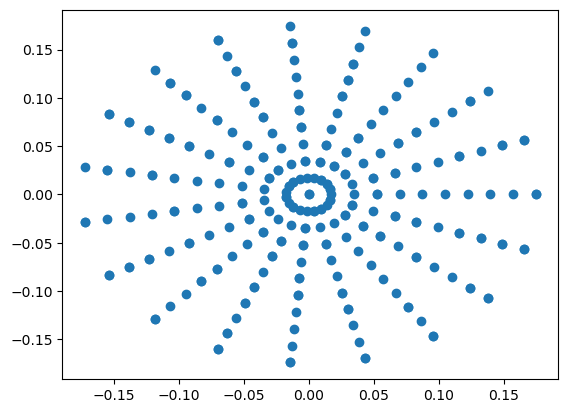

In [20]:
import matplotlib.pyplot as plt

plt.scatter(*true.T.cpu())

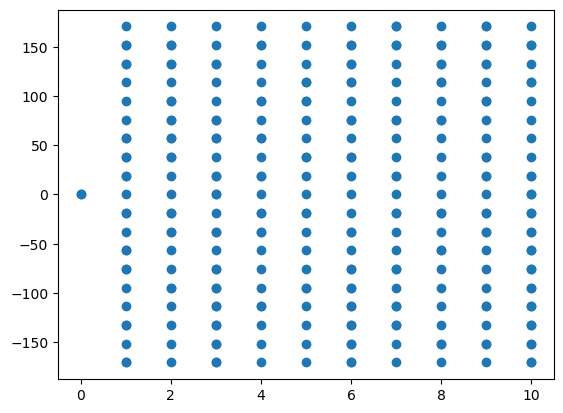

In [21]:
phi_true, theta_true = rpy2spherical(true.cpu().numpy())
phi_true, theta_true = np.degrees(phi_true), np.degrees(theta_true)

plt.scatter(phi_true, theta_true)

In [22]:
np.sort(theta_true)

array([-1.70526306e+02, -1.70526306e+02, -1.70526306e+02, -1.70526306e+02,
       -1.70526306e+02, -1.70526306e+02, -1.70526306e+02, -1.70526306e+02,
       -1.70526306e+02, -1.70526306e+02, -1.70526306e+02, -1.70526306e+02,
       -1.70526306e+02, -1.70526306e+02, -1.51578934e+02, -1.51578934e+02,
       -1.51578934e+02, -1.51578934e+02, -1.51578934e+02, -1.51578934e+02,
       -1.51578934e+02, -1.51578934e+02, -1.51578934e+02, -1.51578934e+02,
       -1.51578934e+02, -1.51578934e+02, -1.51578934e+02, -1.51578934e+02,
       -1.51578934e+02, -1.32631577e+02, -1.32631577e+02, -1.32631577e+02,
       -1.32631577e+02, -1.32631577e+02, -1.32631577e+02, -1.32631577e+02,
       -1.32631577e+02, -1.32631577e+02, -1.32631577e+02, -1.32631577e+02,
       -1.32631577e+02, -1.32631577e+02, -1.32631577e+02, -1.32631577e+02,
       -1.13684204e+02, -1.13684204e+02, -1.13684204e+02, -1.13684204e+02,
       -1.13684204e+02, -1.13684204e+02, -1.13684204e+02, -1.13684204e+02,
       -1.13684204e+02, -

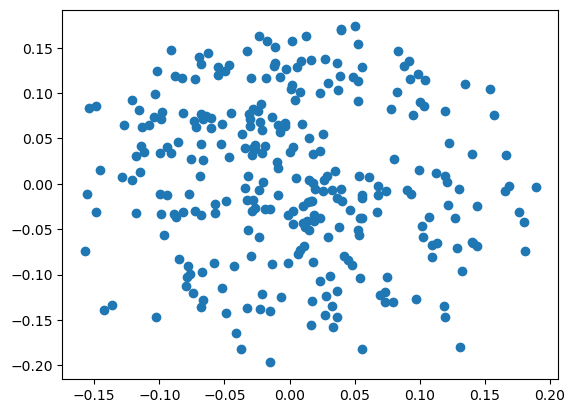

In [23]:
plt.scatter(*pred.T.cpu())

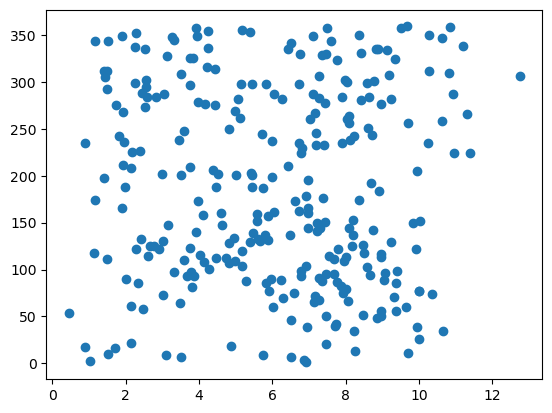

In [24]:
phi_pred, theta_pred = rpy2spherical(pred.cpu())
phi_pred, theta_pred = torch.rad2deg(phi_pred), torch.rad2deg(theta_pred)
theta_pred[theta_pred < 0] = 360 + theta_pred[theta_pred < 0] 

plt.scatter(phi_pred, theta_pred)

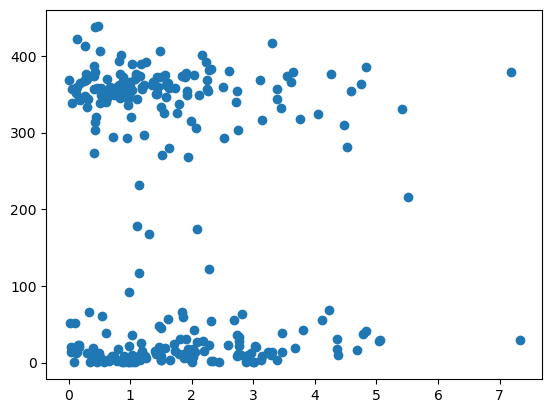

In [25]:
phi_err = torch.abs(phi_pred-phi_true)
theta_err = torch.abs(theta_pred-theta_true)

plt.scatter(phi_err, theta_err)

(array([71., 79., 58., 30., 23., 10., 10.,  2.,  0.,  2.]),
 array([3.29399109e-03, 7.35793889e-01, 1.46829379e+00, 2.20079374e+00,
        2.93329358e+00, 3.66579342e+00, 4.39829350e+00, 5.13079309e+00,
        5.86329317e+00, 6.59579277e+00, 7.32829285e+00]),
 <BarContainer object of 10 artists>)

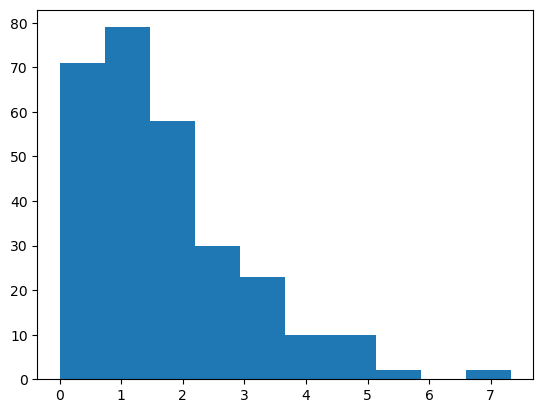

In [26]:
plt.hist(phi_err)

(array([117.,  14.,   3.,   2.,   2.,   1.,  12.,  37.,  88.,   9.]),
 array([6.31103516e-02, 4.38962097e+01, 8.77293091e+01, 1.31562408e+02,
        1.75395508e+02, 2.19228607e+02, 2.63061707e+02, 3.06894806e+02,
        3.50727905e+02, 3.94561005e+02, 4.38394104e+02]),
 <BarContainer object of 10 artists>)

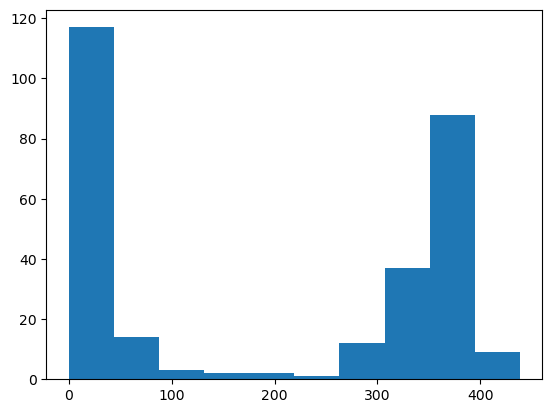

In [27]:
plt.hist(theta_err)

In [28]:
outlier = torch.argwhere(theta_err > 300)

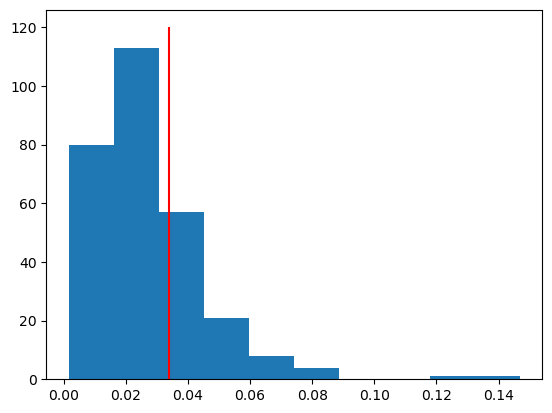

In [30]:
plt.hist(loss)
plt.vlines(0.034, 0, 120, color='r')

In [31]:
np.radians(2)

0.03490658503988659

In [32]:
idx = np.argsort(loss)[::-1]

In [50]:
import pandas as pd

sorted_out = pd.DataFrame({
    'idx': idx,
    'loss': np.degrees(loss[idx]),
    'true_x': true[:, 0].cpu().numpy()[idx],
    'true_y': true[:, 1].cpu().numpy()[idx],
    'n_events': np.array(n_events)[idx],
    'n_edges': np.array(n_edges)[idx]
})

sorted_out.iloc[:15]

,idx,loss,true_x,true_y,n_events,n_edges
0,23,8.414346,-0.138147,-0.074762,1466,16478
1,14,6.816030,-0.122798,-0.066455,1459,17405
2,79,4.511847,0.066822,0.102279,3537,45647
3,104,4.445321,-0.153497,0.083068,7500,107162
4,160,4.370445,-0.172153,-0.028727,1351,13602
5,213,4.367351,-0.014413,-0.173937,2371,29688
6,221,4.228703,-0.014413,0.173937,4228,54661
7,26,4.203744,0.082538,0.028335,2719,38203
8,191,4.125558,0.055092,0.042880,3576,46626
9,166,3.969540,0.025707,-0.101515,724,8137


In [52]:
sorted_out.iloc[np.argsort(sorted_out['n_events'])]

,idx,loss,true_x,true_y,n_events,n_edges
125,181,1.534883,-0.021033,-0.047950,609,6335
64,143,2.028167,-0.017215,-0.002873,630,6319
9,166,3.969540,0.025707,-0.101515,724,8137
22,161,3.093215,-0.046049,-0.024921,726,7525
229,44,0.741175,-0.021033,-0.047950,783,8850
...,...,...,...,...,...,...
156,276,1.242968,-0.012972,0.156543,7500,104103
157,204,1.234380,-0.034431,-0.005745,7500,110154
158,135,1.228937,-0.138147,0.074762,7500,106348
188,133,1.053236,0.165076,-0.056671,7500,113351


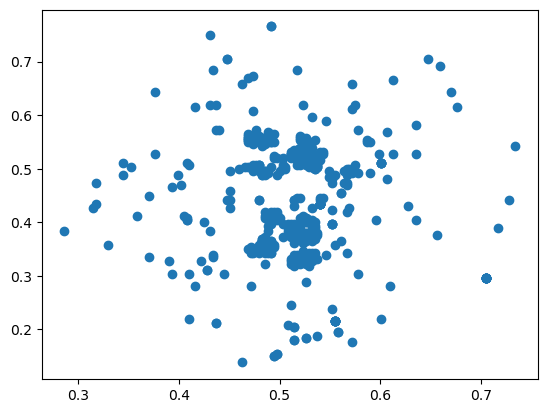

In [61]:
plt.scatter(*tm.val_data[143].pos[:,:2].T)

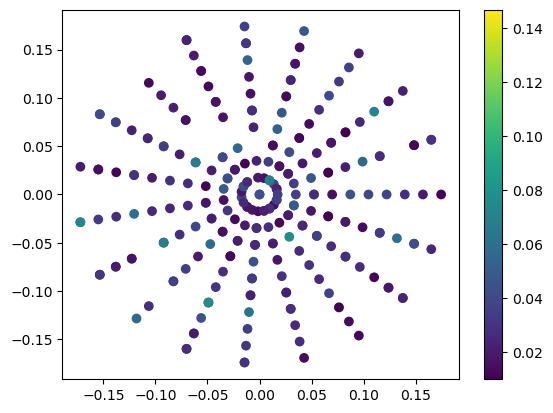

In [38]:
thresh = 0.01
plt.scatter(sorted_out['true_x'][loss > thresh], sorted_out['true_y'][loss > thresh], c=loss[loss > thresh], cmap='viridis')
plt.colorbar()
plt.show()

In [62]:
ex.

In [3]:
from imports.ExtractContactCases import ExtractContactCases

ex = ExtractContactCases(
    tactile_bag_dir='../data/bags/data2/',
    outdir = '../data/extractions/20ms_allevents/'
)

In [37]:
from imports.TactileDataset import TactileDataset
from torch_geometric.loader import DataLoader

train = TactileDataset(ex.outdir / 'train')
train_loader = DataLoader(train, batch_size=8)

{'bag': '/l/proj/kuin0034/hussain/tactile/data/bags/data1', 'train_prop': 0.75, 'delta_t': 100000000.0, 'margin': -100000000.0, 'min_n_events': 3500, 'n_init_events': -1, 'center': [180, 117], 'circle_rad': 85, 'case_span': 2660000000.0, 'N_examples': 20, 'possible_angles': [0.017453292519943295, 0.03490658503988659, 0.05235987755982989, 0.06981317007977318, 0.08726646259971647, 0.10471975511965978, 0.12217304763960307, 0.13962634015954636, 0.15707963267948966, 0.17453292519943295], 'theta': 'full', 'augmentations': [], 'n': 2138, 'dropped_cases': 154}


In [7]:
import torch
from models.modules import GraphRes

model = GraphRes().cuda()
model.load_state_dict(torch.load('../results/20ms_allevents/state_dict'))
train

TactileDataset(1716)

In [42]:
from torch_geometric.utils import degree
pred = []
true = []
n_events = []
n_edges = []
n_comps = []
deg = []


from torch_geometric.utils import to_networkx
from tqdm.auto import tqdm
import networkx as nx

for v in tqdm(train_loader):
    with torch.no_grad():
        for i in range(len(v)):
            n_events.append(v[i].x.shape[0])
            n_edges.append(v[i].edge_index.shape[1]) 
        
        deg.append(torch.mean(degree(v[i].edge_index[0])))
        #pred.append(model(v.cuda()))
        true.append(v.cpu().y)

    v.detach().cpu()
    torch.cuda.empty_cache()
#pred = torch.vstack(pred).cpu()
true = torch.vstack(true).cpu()

  0%|          | 0/215 [00:00<?, ?it/s]

(array([  1.,   2.,   3.,   1.,   1.,   1.,   7.,  20.,  45., 134.]),
 array([11.5671463 , 11.99884701, 12.43054771, 12.86224937, 13.29395008,
        13.72565079, 14.15735149, 14.5890522 , 15.02075386, 15.45245457,
        15.88415527]),
 <BarContainer object of 10 artists>)

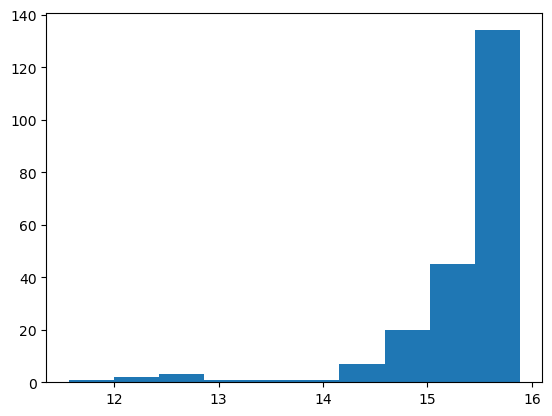

In [43]:
plt.hist(deg)

In [9]:
from torch_geometric.utils import to_scipy_sparse_matrix

n_comps = []
train = TactileDataset(ex.outdir / 'train')
train_loader = DataLoader(train, batch_size=8)


for v in tqdm(train_loader):
    for i in range(len(v)):
        import scipy.sparse as sp

        adj = to_scipy_sparse_matrix(v[i].edge_index, num_nodes=v[i].num_nodes)

        num_components, component = sp.csgraph.connected_components(adj, )
        
        n_comps.append(num_components) w


{'bag': '/l/proj/kuin0034/hussain/tactile/data/bags/data1', 'train_prop': 0.75, 'delta_t': 100000000.0, 'margin': -100000000.0, 'min_n_events': 3500, 'n_init_events': -1, 'center': [180, 117], 'circle_rad': 85, 'case_span': 2660000000.0, 'N_examples': 20, 'possible_angles': [0.017453292519943295, 0.03490658503988659, 0.05235987755982989, 0.06981317007977318, 0.08726646259971647, 0.10471975511965978, 0.12217304763960307, 0.13962634015954636, 0.15707963267948966, 0.17453292519943295], 'theta': 'full', 'augmentations': [], 'n': 2138, 'dropped_cases': 154}


  0%|          | 0/215 [00:00<?, ?it/s]

In [27]:
component.shape

(11880,)

In [28]:
adj

<11880x11880 sparse matrix of type '<class 'numpy.float32'>'
	with 184636 stored elements in COOrdinate format>

In [13]:
loss_func = torch.nn.L1Loss()

loss_func(pred, true)

tensor(0.0572)

In [14]:
loss = torch.mean(torch.abs(pred-true), dim=1)
loss

tensor([0.0145, 0.0804, 0.0674,  ..., 0.0158, 0.0201, 0.0333])

In [15]:
torch.median(loss)

tensor(0.0537)

(array([340., 358., 342., 306., 215., 122.,  23.,   5.,   2.,   3.]),
 array([0.        , 0.02198826, 0.04397651, 0.06596477, 0.08795302,
        0.10994128, 0.13192953, 0.15391779, 0.17590605, 0.1978943 ,
        0.21988256]),
 <BarContainer object of 10 artists>)

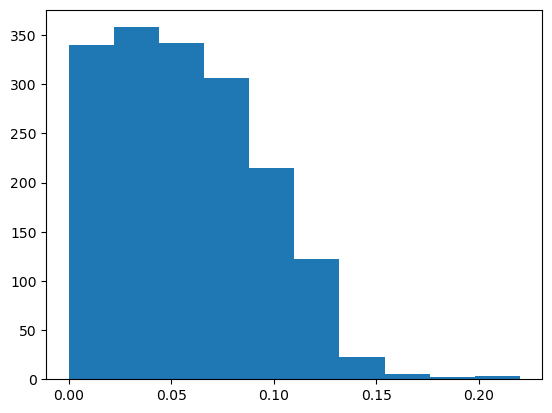

In [16]:
import matplotlib.pyplot as plt

plt.hist(loss.cpu())

In [17]:
import numpy as np
idx = np.argsort(loss.cpu())

In [18]:
len(n_events)

1716

In [19]:
import pandas as pd

st = pd.DataFrame(
{
    'idx': idx,
    'loss': loss[idx],
    'n_events': np.array(n_events)[idx],
    'n_edges': np.array(n_edges)[idx],
    'n_comps': np.array(n_comps)[idx]
    
}
)


In [20]:
st.iloc[:10]

,idx,loss,n_events,n_edges,n_comps
0,1019,0.000000,2161,28990,109
1,77,0.000000,5030,75327,76
2,741,0.000000,9743,150047,112
3,572,0.000000,6898,105047,93
4,1651,0.000000,6684,102822,85
5,1572,0.000000,9980,154627,83
6,1368,0.001300,7217,109800,69
7,704,0.001402,12279,192410,180
8,824,0.001643,18679,293711,109
9,336,0.002271,1431,18873,85


In [22]:
st.corr()

,idx,loss,n_events,n_edges,n_comps
idx,1.000000,-0.018422,-0.008698,-0.008504,-0.006038
loss,-0.018422,1.000000,0.090973,0.088458,-0.067922
n_events,-0.008698,0.090973,1.000000,0.999908,0.464989
n_edges,-0.008504,0.088458,0.999908,1.000000,0.472136
n_comps,-0.006038,-0.067922,0.464989,0.472136,1.000000


In [25]:
st.sort_values('n_events')

,idx,loss,n_events,n_edges,n_comps
154,1461,0.011497,422,3412,108
181,21,0.012079,534,5550,99
379,1412,0.023657,549,5078,120
562,1624,0.034908,570,5561,118
769,686,0.048315,696,6857,102
...,...,...,...,...,...
639,400,0.038743,30778,488932,173
1393,1505,0.092319,31490,500175,139
1622,1666,0.117484,31768,504365,174
1474,369,0.099139,33464,532531,183


In [21]:
st.iloc[-10:]

,idx,loss,n_events,n_edges,n_comps
1706,818,0.154968,5079,76143,79
1707,1194,0.157936,6504,95638,73
1708,1578,0.159691,3846,54395,68
1709,106,0.164457,27202,432101,201
1710,1178,0.172058,11070,168052,44
1711,1218,0.182229,4405,62796,74
1712,114,0.185119,13004,201909,61
1713,786,0.198065,21459,339348,171
1714,1050,0.210468,5766,84971,72
1715,1266,0.219883,18031,283154,99
